# MRI Classification Using PyTorch

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
from torchvision.datasets import ImageFolder
import seaborn as sns
import shutil
import json
import gc

LEARNING_RATE = 0.00001
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 8
DROPOUT_RATE = 0.4
PRETRAINED_WEIGHTS = True

NUM_EPOCHS = 20
PATIENCE = 5


## Data Preparation
Load the dataset and split it into training and validation sets, starting with first fold generated by data_preparation.ipynb

In [2]:
with open('mean_std.json', 'r') as f:
    mean_std = json.load(f)

mean = mean_std['mean']
std = mean_std['std']

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load data for fold 0
k_folds = 5
base_dir = 'dataset_kfold'
fold = 0
train_dir = os.path.join(base_dir, f'fold_{fold}', 'train')
val_dir = os.path.join(base_dir, f'fold_{fold}', 'val')
fold += 1

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

## Define the Model

In [3]:
# Define the ResNet model
class SimpleResNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleResNet, self).__init__()
        self.model = models.vgg16(pretrained=PRETRAINED_WEIGHTS)
        self.model.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        return self.model(x)

# Instantiate the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleResNet(num_classes=num_classes).to(device)

/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [5]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    print(f'Epoch {epoch}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return epoch_loss, accuracy

# Define the validation function
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            all_probs.extend(torch.softmax(output, dim=1).cpu().numpy())  # Get probabilities

    val_loss /= len(val_loader)
    accuracy = 100. * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return val_loss, accuracy, all_preds, all_labels, all_probs


## Start training the model

In [6]:
# Training and validation loop with early stopping
num_epochs = NUM_EPOCHS
patience = PATIENCE
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
all_preds = []
all_labels = []
all_probs = []  # To store the probabilities for AUC-ROC

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc, preds, labels, probs = validate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    all_preds.extend(preds)
    all_labels.extend(labels)
    all_probs.extend(probs)
    
    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f} - '
          f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}')
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print('Early stopping!')
        break
    
# Calculate AUC-ROC
all_probs = np.array(all_probs)  # Convert to numpy array
auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average=None)
for i, class_auc in enumerate(auc_roc):
        print(f"AUC-ROC for class {val_dataset.classes[i]}: {class_auc:.4f}")

Epoch 0, Loss: 1.2536, Accuracy: 41.41%
Validation Loss: 0.9524, Accuracy: 73.96%
Epoch 1/20 - Train loss: 1.2536, Train accuracy: 41.4062 - Val loss: 0.9524, Val accuracy: 73.9583
Epoch 1, Loss: 0.8442, Accuracy: 67.97%
Validation Loss: 0.5450, Accuracy: 81.25%
Epoch 2/20 - Train loss: 0.8442, Train accuracy: 67.9688 - Val loss: 0.5450, Val accuracy: 81.2500
Epoch 2, Loss: 0.5517, Accuracy: 79.95%
Validation Loss: 0.3776, Accuracy: 86.46%
Epoch 3/20 - Train loss: 0.5517, Train accuracy: 79.9479 - Val loss: 0.3776, Val accuracy: 86.4583
Epoch 3, Loss: 0.4319, Accuracy: 83.85%
Validation Loss: 0.2841, Accuracy: 88.54%
Epoch 4/20 - Train loss: 0.4319, Train accuracy: 83.8542 - Val loss: 0.2841, Val accuracy: 88.5417
Epoch 4, Loss: 0.3776, Accuracy: 85.16%
Validation Loss: 0.2749, Accuracy: 92.71%
Epoch 5/20 - Train loss: 0.3776, Train accuracy: 85.1562 - Val loss: 0.2749, Val accuracy: 92.7083
Epoch 5, Loss: 0.3053, Accuracy: 90.36%
Validation Loss: 0.3425, Accuracy: 86.46%
Epoch 6/20 - 

## Visualize

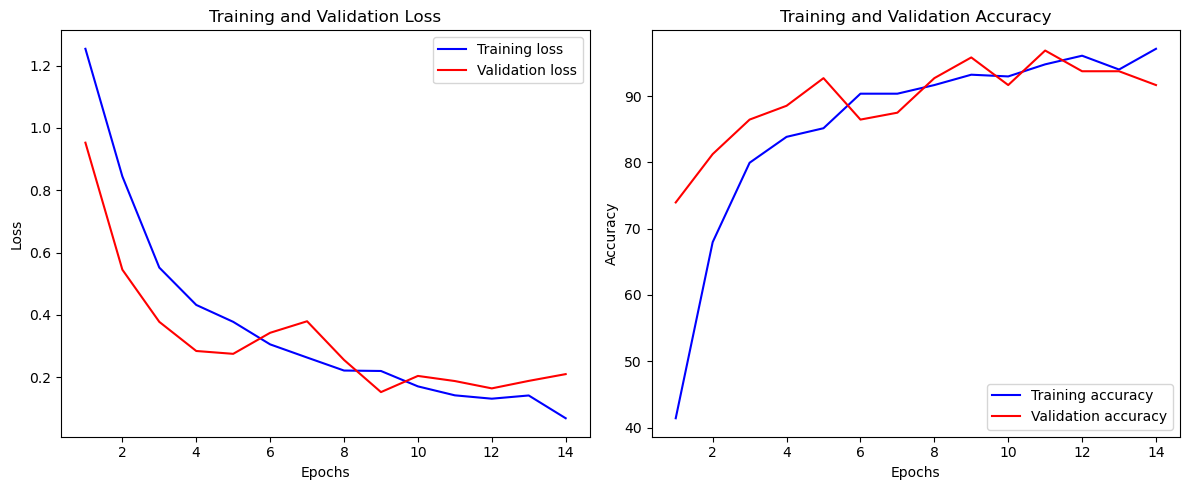

In [7]:
# Plotting the results
actual_epochs = range(1, epoch + 2)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(actual_epochs, train_losses, 'b', label='Training loss')
plt.plot(actual_epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(actual_epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(actual_epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


<Figure size 1000x700 with 0 Axes>

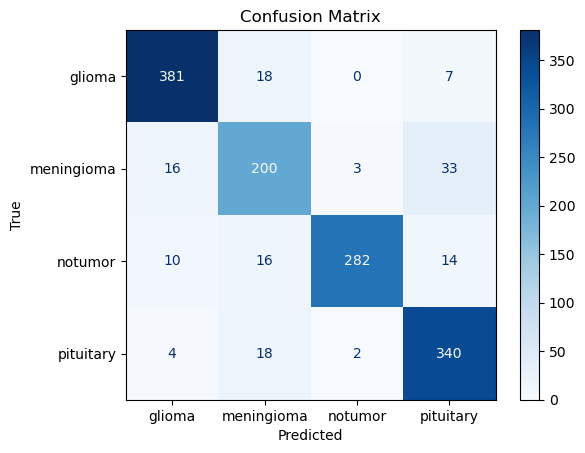

In [8]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=val_dataset.classes)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Remaining k-fold, train and visualize

In [9]:
fold_results = []

# Loop over each fold
for f in range(1, k_folds):
    print(f'Fold {f + 1}/{k_folds}')

    # Load data for fold
    train_dir = os.path.join(base_dir, f'fold_{f}', 'train')
    val_dir = os.path.join(base_dir, f'fold_{f}', 'val')

    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Set device and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleResNet(num_classes=num_classes).to(device)

    # Optimizer and criterion
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    # Early stopping parameters
    num_epochs = NUM_EPOCHS
    patience = PATIENCE
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    all_preds = []
    all_labels = []
    all_probs = []

    # Training loop with early stopping
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc, preds, labels, probs = validate(model, device, val_loader, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        all_preds.extend(preds)
        all_labels.extend(labels)
        all_probs.extend(probs)

        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f} - '
              f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model if necessary
            torch.save(model.state_dict(), f'best_model_fold_{f}.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping!')
            break

    all_probs = np.array(all_probs)
    auc_roc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average=None)
    
    # Store fold results
    fold_results.append({
        'fold': f,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss,
        'conf_matrix': conf_matrix,
        'val_true_classes': all_labels,
        'val_predictions': all_preds,
        'auc_roc': auc_roc
    })

    # Free CUDA memory after training
    torch.cuda.empty_cache()
    gc.collect()

Fold 2/5


/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Loss: 1.2725, Accuracy: 40.36%
Validation Loss: 1.0113, Accuracy: 65.62%
Epoch 1/20 - Train loss: 1.2725, Train accuracy: 40.3646 - Val loss: 1.0113, Val accuracy: 65.6250
Epoch 1, Loss: 0.8064, Accuracy: 71.88%
Validation Loss: 0.6252, Accuracy: 78.12%
Epoch 2/20 - Train loss: 0.8064, Train accuracy: 71.8750 - Val loss: 0.6252, Val accuracy: 78.1250
Epoch 2, Loss: 0.5858, Accuracy: 76.82%
Validation Loss: 0.5641, Accuracy: 75.00%
Epoch 3/20 - Train loss: 0.5858, Train accuracy: 76.8229 - Val loss: 0.5641, Val accuracy: 75.0000
Epoch 3, Loss: 0.4098, Accuracy: 84.11%
Validation Loss: 0.4664, Accuracy: 86.46%
Epoch 4/20 - Train loss: 0.4098, Train accuracy: 84.1146 - Val loss: 0.4664, Val accuracy: 86.4583
Epoch 4, Loss: 0.3082, Accuracy: 89.58%
Validation Loss: 0.4963, Accuracy: 83.33%
Epoch 5/20 - Train loss: 0.3082, Train accuracy: 89.5833 - Val loss: 0.4963, Val accuracy: 83.3333
Epoch 5, Loss: 0.2825, Accuracy: 90.36%
Validation Loss: 0.4442, Accuracy: 82.29%
Epoch 6/20 - 

/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Loss: 1.2749, Accuracy: 43.75%
Validation Loss: 0.9968, Accuracy: 67.71%
Epoch 1/20 - Train loss: 1.2749, Train accuracy: 43.7500 - Val loss: 0.9968, Val accuracy: 67.7083
Epoch 1, Loss: 0.7463, Accuracy: 71.09%
Validation Loss: 0.5593, Accuracy: 81.25%
Epoch 2/20 - Train loss: 0.7463, Train accuracy: 71.0938 - Val loss: 0.5593, Val accuracy: 81.2500
Epoch 2, Loss: 0.4974, Accuracy: 82.29%
Validation Loss: 0.6475, Accuracy: 71.88%
Epoch 3/20 - Train loss: 0.4974, Train accuracy: 82.2917 - Val loss: 0.6475, Val accuracy: 71.8750
Epoch 3, Loss: 0.4196, Accuracy: 83.07%
Validation Loss: 0.4763, Accuracy: 82.29%
Epoch 4/20 - Train loss: 0.4196, Train accuracy: 83.0729 - Val loss: 0.4763, Val accuracy: 82.2917
Epoch 4, Loss: 0.2596, Accuracy: 90.10%
Validation Loss: 0.3135, Accuracy: 86.46%
Epoch 5/20 - Train loss: 0.2596, Train accuracy: 90.1042 - Val loss: 0.3135, Val accuracy: 86.4583
Epoch 5, Loss: 0.2454, Accuracy: 92.19%
Validation Loss: 0.4227, Accuracy: 84.38%
Epoch 6/20 - 

/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Loss: 1.2458, Accuracy: 45.57%
Validation Loss: 0.9784, Accuracy: 66.67%
Epoch 1/20 - Train loss: 1.2458, Train accuracy: 45.5729 - Val loss: 0.9784, Val accuracy: 66.6667
Epoch 1, Loss: 0.8550, Accuracy: 67.97%
Validation Loss: 0.6506, Accuracy: 73.96%
Epoch 2/20 - Train loss: 0.8550, Train accuracy: 67.9688 - Val loss: 0.6506, Val accuracy: 73.9583
Epoch 2, Loss: 0.6090, Accuracy: 78.65%
Validation Loss: 0.5666, Accuracy: 72.92%
Epoch 3/20 - Train loss: 0.6090, Train accuracy: 78.6458 - Val loss: 0.5666, Val accuracy: 72.9167
Epoch 3, Loss: 0.5173, Accuracy: 79.17%
Validation Loss: 0.4161, Accuracy: 83.33%
Epoch 4/20 - Train loss: 0.5173, Train accuracy: 79.1667 - Val loss: 0.4161, Val accuracy: 83.3333
Epoch 4, Loss: 0.3357, Accuracy: 88.80%
Validation Loss: 0.4000, Accuracy: 85.42%
Epoch 5/20 - Train loss: 0.3357, Train accuracy: 88.8021 - Val loss: 0.4000, Val accuracy: 85.4167
Epoch 5, Loss: 0.2945, Accuracy: 89.06%
Validation Loss: 0.3538, Accuracy: 85.42%
Epoch 6/20 - 

/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Loss: 1.2960, Accuracy: 40.36%
Validation Loss: 1.0543, Accuracy: 67.71%
Epoch 1/20 - Train loss: 1.2960, Train accuracy: 40.3646 - Val loss: 1.0543, Val accuracy: 67.7083
Epoch 1, Loss: 0.8787, Accuracy: 67.45%
Validation Loss: 0.6087, Accuracy: 73.96%
Epoch 2/20 - Train loss: 0.8787, Train accuracy: 67.4479 - Val loss: 0.6087, Val accuracy: 73.9583
Epoch 2, Loss: 0.5972, Accuracy: 78.39%
Validation Loss: 0.4172, Accuracy: 86.46%
Epoch 3/20 - Train loss: 0.5972, Train accuracy: 78.3854 - Val loss: 0.4172, Val accuracy: 86.4583
Epoch 3, Loss: 0.4627, Accuracy: 85.42%
Validation Loss: 0.4030, Accuracy: 86.46%
Epoch 4/20 - Train loss: 0.4627, Train accuracy: 85.4167 - Val loss: 0.4030, Val accuracy: 86.4583
Epoch 4, Loss: 0.3840, Accuracy: 85.68%
Validation Loss: 0.3886, Accuracy: 86.46%
Epoch 5/20 - Train loss: 0.3840, Train accuracy: 85.6771 - Val loss: 0.3886, Val accuracy: 86.4583
Epoch 5, Loss: 0.3199, Accuracy: 89.84%
Validation Loss: 0.3741, Accuracy: 85.42%
Epoch 6/20 - 

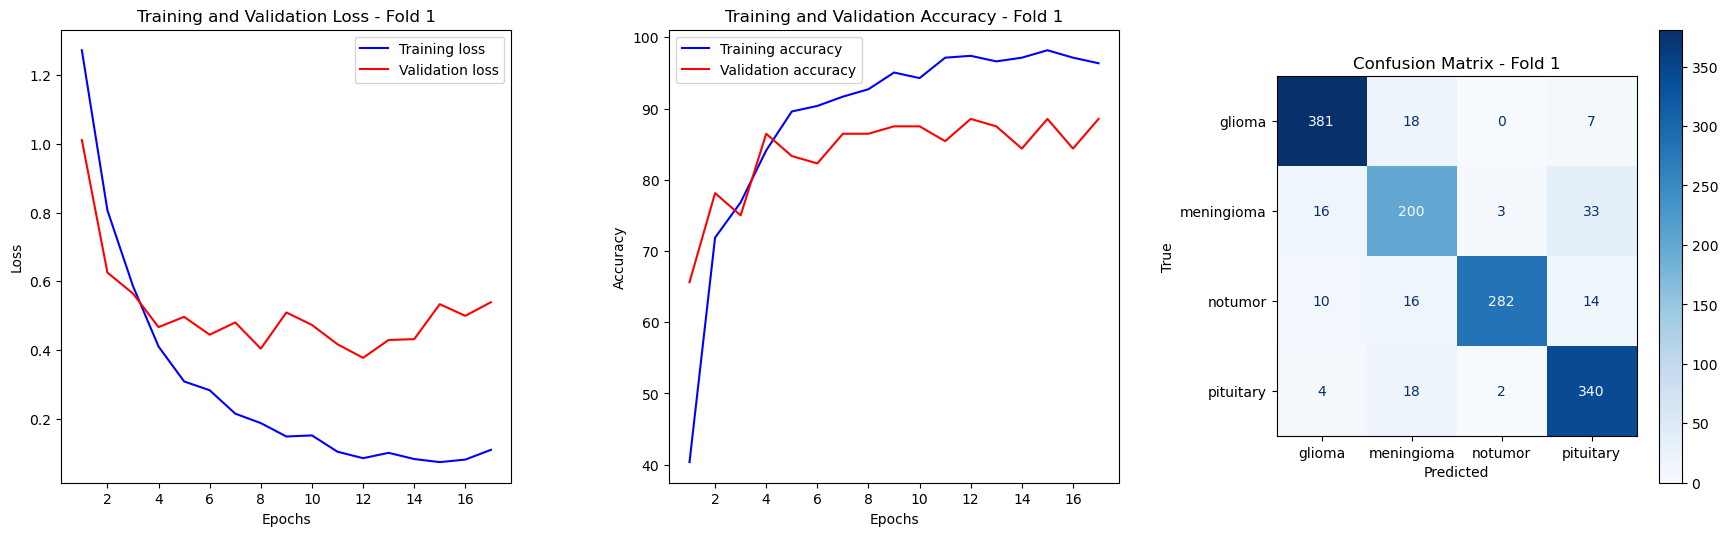

Classification Report for Fold 1:
              precision    recall  f1-score   support

      glioma       0.96      0.86      0.91       510
  meningioma       0.72      0.72      0.72       425
     notumor       0.83      0.90      0.86       255
   pituitary       0.83      0.89      0.86       442

    accuracy                           0.84      1632
   macro avg       0.84      0.84      0.84      1632
weighted avg       0.84      0.84      0.84      1632

Class-wise TP, TN, FP, FN for Fold 1:
Class: glioma, TP: 381, TN: 908, FP: 30, FN: 25
Class: meningioma, TP: 200, TN: 1040, FP: 52, FN: 52
Class: notumor, TP: 282, TN: 1017, FP: 5, FN: 40
Class: pituitary, TP: 340, TN: 926, FP: 54, FN: 24
AUC-ROC for class glioma: 0.9795
AUC-ROC for class meningioma: 0.8866
AUC-ROC for class notumor: 0.9861
AUC-ROC for class pituitary: 0.9639


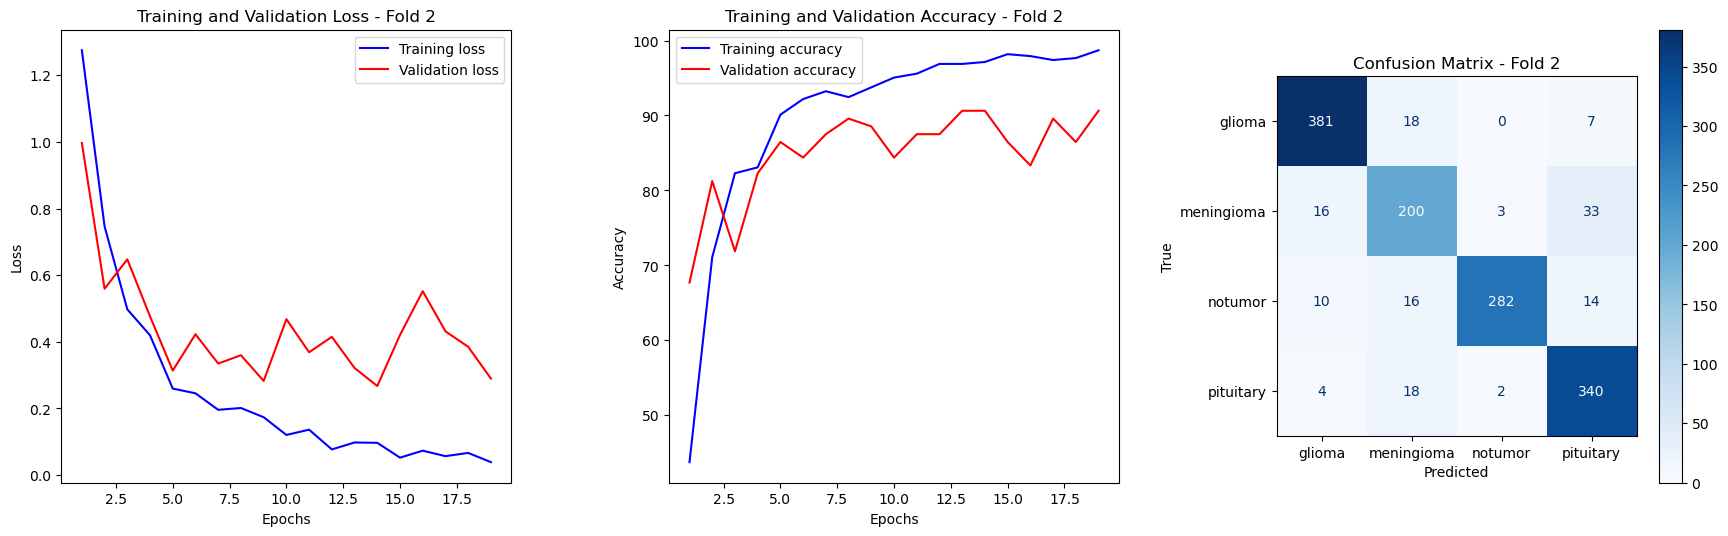

Classification Report for Fold 2:
              precision    recall  f1-score   support

      glioma       0.87      0.90      0.89       304
  meningioma       0.82      0.76      0.79       494
     notumor       0.92      0.83      0.87       570
   pituitary       0.80      0.95      0.87       456

    accuracy                           0.85      1824
   macro avg       0.85      0.86      0.85      1824
weighted avg       0.85      0.85      0.85      1824

Class-wise TP, TN, FP, FN for Fold 2:
Class: glioma, TP: 381, TN: 908, FP: 30, FN: 25
Class: meningioma, TP: 200, TN: 1040, FP: 52, FN: 52
Class: notumor, TP: 282, TN: 1017, FP: 5, FN: 40
Class: pituitary, TP: 340, TN: 926, FP: 54, FN: 24
AUC-ROC for class glioma: 0.9723
AUC-ROC for class meningioma: 0.9423
AUC-ROC for class notumor: 0.9795
AUC-ROC for class pituitary: 0.9788


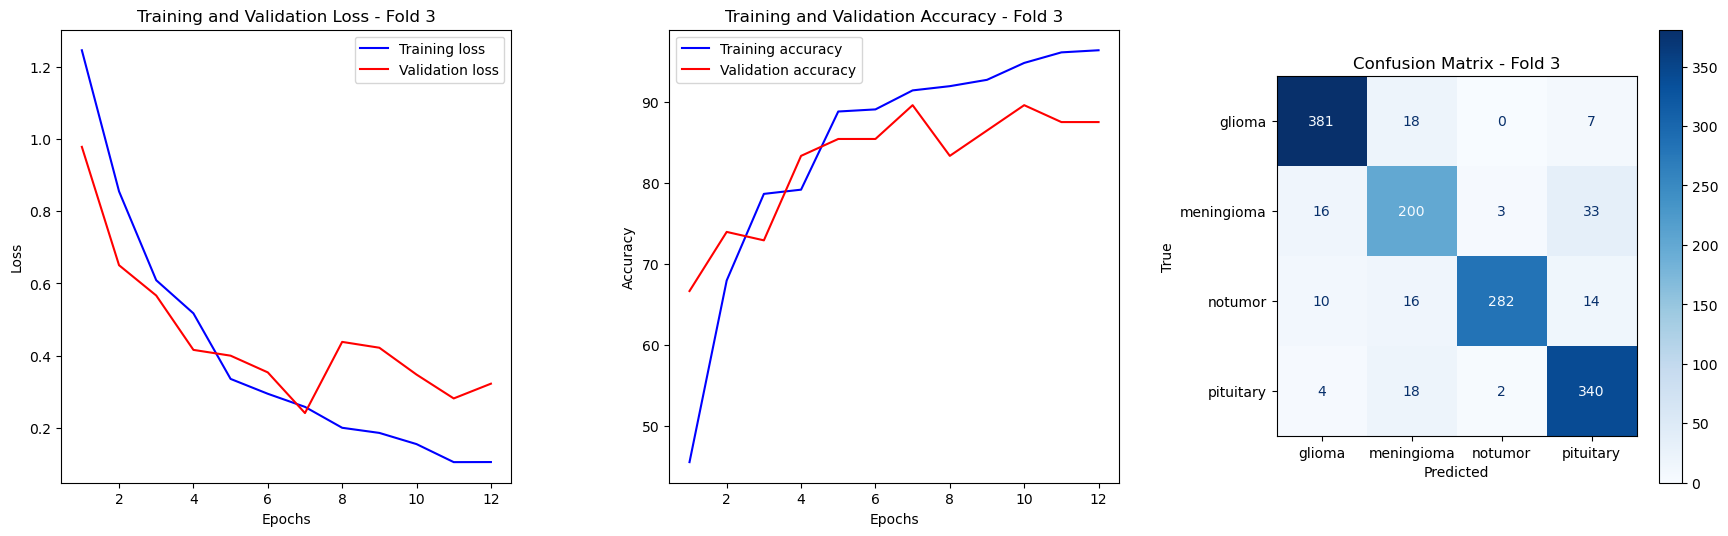

Classification Report for Fold 3:
              precision    recall  f1-score   support

      glioma       0.94      0.87      0.90       276
  meningioma       0.80      0.68      0.73       336
     notumor       0.77      0.90      0.83       264
   pituitary       0.82      0.89      0.85       276

    accuracy                           0.83      1152
   macro avg       0.83      0.84      0.83      1152
weighted avg       0.83      0.83      0.82      1152

Class-wise TP, TN, FP, FN for Fold 3:
Class: glioma, TP: 381, TN: 908, FP: 30, FN: 25
Class: meningioma, TP: 200, TN: 1040, FP: 52, FN: 52
Class: notumor, TP: 282, TN: 1017, FP: 5, FN: 40
Class: pituitary, TP: 340, TN: 926, FP: 54, FN: 24
AUC-ROC for class glioma: 0.9818
AUC-ROC for class meningioma: 0.9288
AUC-ROC for class notumor: 0.9675
AUC-ROC for class pituitary: 0.9763


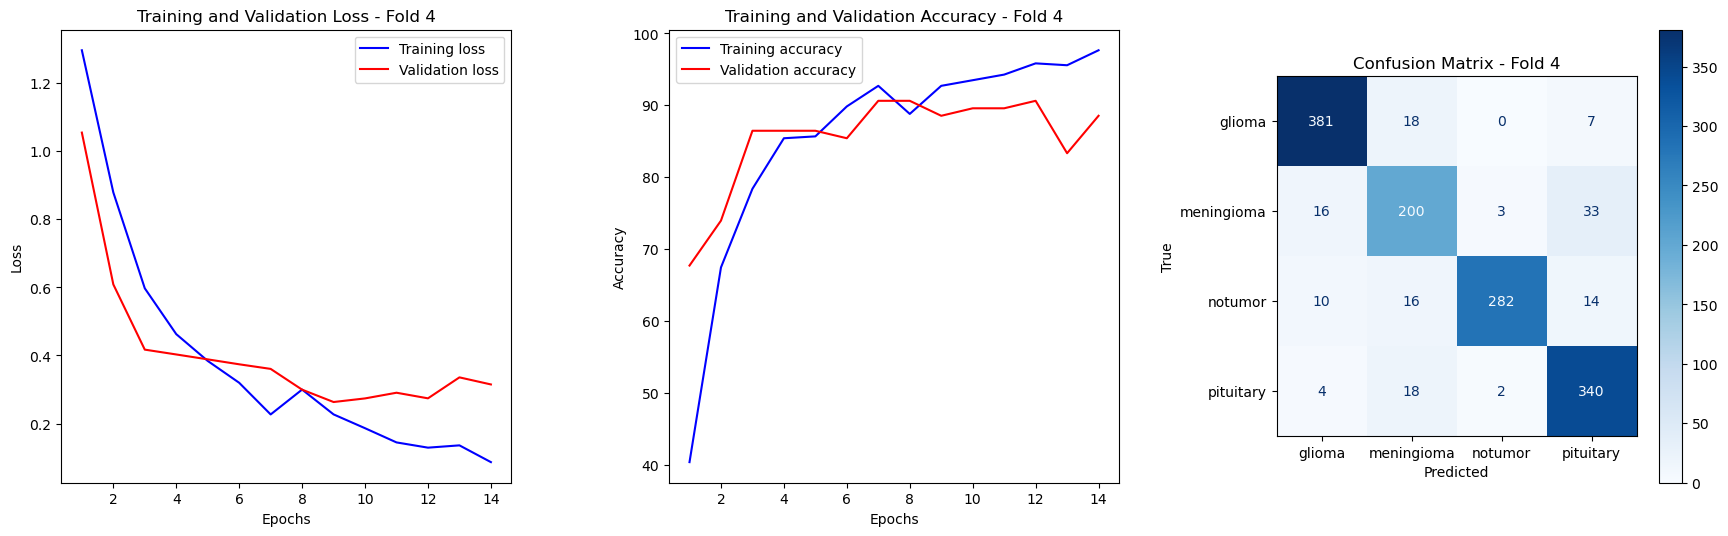

Classification Report for Fold 4:
              precision    recall  f1-score   support

      glioma       0.84      0.88      0.86       308
  meningioma       0.76      0.68      0.72       322
     notumor       0.91      0.92      0.92       420
   pituitary       0.88      0.93      0.91       294

    accuracy                           0.86      1344
   macro avg       0.85      0.85      0.85      1344
weighted avg       0.85      0.86      0.85      1344

Class-wise TP, TN, FP, FN for Fold 4:
Class: glioma, TP: 381, TN: 908, FP: 30, FN: 25
Class: meningioma, TP: 200, TN: 1040, FP: 52, FN: 52
Class: notumor, TP: 282, TN: 1017, FP: 5, FN: 40
Class: pituitary, TP: 340, TN: 926, FP: 54, FN: 24
AUC-ROC for class glioma: 0.9735
AUC-ROC for class meningioma: 0.9231
AUC-ROC for class notumor: 0.9844
AUC-ROC for class pituitary: 0.9880
Mean Validation Accuracy across all folds: 88.80%
Variance of Validation Accuracy across all folds: 1.29%


In [13]:
# Plotting results for each fold
for fold_result in fold_results:
    actual_epochs = range(1, len(fold_result['train_losses']) + 1)
    plt.figure(figsize=(18, 6))

    # Plot Training and Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(actual_epochs, fold_result['train_losses'], 'b', label='Training loss')
    plt.plot(actual_epochs, fold_result['val_losses'], 'r', label='Validation loss')
    plt.title(f'Training and Validation Loss - Fold {fold_result["fold"]}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(actual_epochs, fold_result['train_accuracies'], 'b', label='Training accuracy')
    plt.plot(actual_epochs, fold_result['val_accuracies'], 'r', label='Validation accuracy')
    plt.title(f'Training and Validation Accuracy - Fold {fold_result["fold"]}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Confusion Matrix
    plt.subplot(1, 3, 3)
    conf_matrix = fold_result['conf_matrix']
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=val_dataset.classes)
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f'Confusion Matrix - Fold {fold_result["fold"]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout(pad=3.0)
    plt.show()

    # Print classification report for this fold
    print(f'Classification Report for Fold {fold_result["fold"]}:')
    print(classification_report(fold_result['val_true_classes'], fold_result['val_predictions'], target_names=val_dataset.classes))

    # Calculate TP, TN, FP, FN for each class in this fold
    class_names = val_dataset.classes
    table_data = []
    for i, class_name in enumerate(class_names):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp
        tn = np.sum(conf_matrix) - tp - fp - fn
        table_data.append([class_name, tp, tn, fp, fn])

    # Print the TP, TN, FP, FN table for this fold
    print(f"Class-wise TP, TN, FP, FN for Fold {fold_result['fold']}:")
    for row in table_data:
        print(f"Class: {row[0]}, TP: {row[1]}, TN: {row[2]}, FP: {row[3]}, FN: {row[4]}")

    for i, class_auc in enumerate(fold_result['auc_roc']):
        print(f"AUC-ROC for class {val_dataset.classes[i]}: {class_auc:.4f}")

# Calculate mean and variance of validation accuracies across all folds
val_accuracies_all_folds = [result['val_accuracies'][-1] for result in fold_results]  # Take the last epoch's accuracy from each fold
mean_accuracy = np.mean(val_accuracies_all_folds)
variance_accuracy = np.var(val_accuracies_all_folds)

# Display the mean and variance
print(f'Mean Validation Accuracy across all folds: {mean_accuracy:.2f}%')
print(f'Variance of Validation Accuracy across all folds: {variance_accuracy:.2f}%')
